### Implementation of a GAN (not DCGAN...)

In [1]:
import tflearn.datasets.oxflower17 as oxflower17
X, Y = oxflower17.load_data(one_hot=True, resize_pics=(15, 15))

(1360, 15, 15, 3)


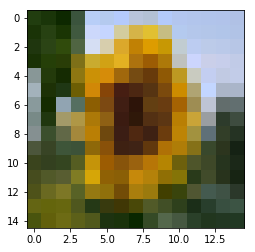

In [2]:
print X.shape # 30x30 img

import matplotlib.pylab as plt
%matplotlib inline
import numpy as np

plt.imshow(X[18])

In [3]:
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

## Setup

In [4]:
import tensorflow as tf

tf.flags.DEFINE_float("learning_rate",  0.0002, "LR")
tf.flags.DEFINE_integer("training_iters", 5000, "Training iterations")
tf.flags.DEFINE_integer("batch_size", 128, "Batch Size")
tf.flags.DEFINE_integer("image_size", 15, "Image length or height")

tf.flags.DEFINE_integer("z_noise_dim", 100, "length of Z")
tf.flags.DEFINE_integer("gen_hidden_dim", 512, "gen dim")
tf.flags.DEFINE_integer("disc_hidden_dim", 512, "disc dim")

FLAGS = tf.flags.FLAGS

## GAN

In [12]:
## Slightly better than Xavior initialization
## See: http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

class GAN():
    def __init__(self, lr=0.0002):
        ## 30x30x3
        self.gen_input = tf.placeholder(tf.float32, shape=[None, FLAGS.z_noise_dim], name='input_noise')
        self.disc_input = tf.placeholder(tf.float32, shape=[None, FLAGS.image_size, FLAGS.image_size, 3],\
                                         name='disc_input')
#         self.disc_input_grayscale = tf.contrib.layers.flatten(tf.image.rgb_to_grayscale(self.disc_input))
        self.disc_input_grayscale = tf.contrib.layers.flatten(self.disc_input)
        
        ## Generator: Z -> fake image
        ## Variables
        self.gen_hidden_w = tf.Variable(glorot_init([FLAGS.z_noise_dim, FLAGS.gen_hidden_dim]))
        self.gen_hidden_b = tf.Variable(tf.zeros([FLAGS.gen_hidden_dim]))
        self.gen_out_w = tf.Variable(glorot_init([FLAGS.gen_hidden_dim, FLAGS.image_size * FLAGS.image_size * 3]))
        self.gen_out_b = tf.Variable(tf.zeros([FLAGS.image_size * FLAGS.image_size * 3]))
        ## Net
        self.gen_layer1 = tf.nn.relu(tf.matmul(self.gen_input, self.gen_hidden_w) + self.gen_hidden_b)
        self.gen_out = tf.nn.sigmoid(tf.matmul(self.gen_layer1, self.gen_out_w) + self.gen_out_b)
        
        ## Discriminator: fake / real image -> P(real)
        ## Variables
        self.disc_hidden_w = tf.Variable(glorot_init([FLAGS.image_size * FLAGS.image_size * 3, FLAGS.disc_hidden_dim]))
        self.disc_hidden_b = tf.Variable(tf.zeros([FLAGS.disc_hidden_dim]))
        self.disc_out_w = tf.Variable(glorot_init([FLAGS.disc_hidden_dim, 1]))
        self.disc_out_b = tf.Variable(tf.zeros([1]))
        ## Net
        def disc_net(disc_input):
            disc_layer1 = tf.nn.relu(tf.matmul(disc_input, self.disc_hidden_w) + self.disc_hidden_b)
            return tf.nn.sigmoid(tf.matmul(disc_layer1, self.disc_out_w) + self.disc_out_b)
        self.disc_fake = disc_net(self.gen_out)
        self.disc_real = disc_net(self.disc_input_grayscale)
        
        
        ## Losses (https://arxiv.org/pdf/1406.2661.pdf)
        self.gen_loss = -tf.reduce_mean(tf.log(self.disc_fake)) # max gen prob
        self.disc_loss = -tf.reduce_mean(tf.log(self.disc_real) + tf.log(1. - self.disc_fake)) # max real prob
        
        self.optimizer_gen = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.5, beta2=0.999)
        self.optimizer_disc = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.5, beta2=0.999)

        self.train_gen = self.optimizer_gen.minimize(self.gen_loss, var_list=[self.gen_hidden_w, self.gen_hidden_b, self.gen_out_w, self.gen_out_b])
        self.train_disc = self.optimizer_disc.minimize(self.disc_loss, var_list=[self.disc_hidden_w, self.disc_hidden_b, self.disc_out_w, self.disc_out_b])

In [15]:
tf.reset_default_graph()

gan = GAN(lr=0.0005)
global_step = tf.Variable(0, name="global_step", trainable=False)
incr_global_step_op = tf.assign(global_step, global_step+1)

init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


## Training

In [16]:
batches = batch_iter(X, FLAGS.batch_size, FLAGS.training_iters)

for batch in batches:
    z = np.random.uniform(-1., 1., size=[batch.shape[0], FLAGS.z_noise_dim])
    feed_dict = {gan.disc_input: batch, gan.gen_input: z}
    _, _, gl, dl, i = sess.run([gan.train_gen, gan.train_disc, gan.gen_loss, gan.disc_loss, incr_global_step_op],
                            feed_dict=feed_dict)
    
    if i % 1000 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))

Step 1: Generator Loss: 0.507239, Discriminator Loss: 1.553735
Step 1000: Generator Loss: 0.877101, Discriminator Loss: 0.913767
Step 2000: Generator Loss: 0.733834, Discriminator Loss: 1.285719
Step 3000: Generator Loss: 0.398820, Discriminator Loss: 1.433516
Step 4000: Generator Loss: 0.569946, Discriminator Loss: 1.251798
Step 5000: Generator Loss: 0.641171, Discriminator Loss: 1.227455
Step 6000: Generator Loss: 1.296036, Discriminator Loss: 1.258152
Step 7000: Generator Loss: 1.168295, Discriminator Loss: 1.222861
Step 8000: Generator Loss: 1.409532, Discriminator Loss: 1.310019
Step 9000: Generator Loss: 1.449273, Discriminator Loss: 1.355887
Step 10000: Generator Loss: 0.842725, Discriminator Loss: 1.271258
Step 11000: Generator Loss: 0.377306, Discriminator Loss: 1.537554


KeyboardInterrupt: 

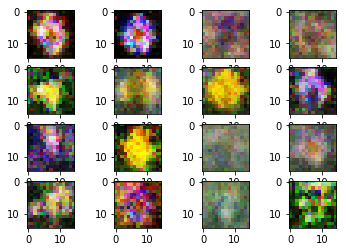

In [20]:
def generate_a_flower():
    z = np.random.uniform(-1., 1., size=[1, 100])
    g = sess.run(gan.gen_out, feed_dict={gan.gen_input: z})
    return g.reshape(15, 15, 3)

n = 4
f, axarr = plt.subplots(n,n)
for i in range(n):
    for j in range(n):
        axarr[i,j].imshow(generate_a_flower())

# plt.imshow(generate_a_flower())